In [61]:
!git clone https://github.com/qiuqiangkong/audioset_tagging_cnn.git

Cloning into 'audioset_tagging_cnn'...
remote: Enumerating objects: 266, done.
remote: Total 266 (delta 0), reused 0 (delta 0), pack-reused 266
Receiving objects: 100% (266/266), 1.44 MiB | 3.62 MiB/s, done.
Resolving deltas: 100% (148/148), done.


In [1]:
ls

audioset_tagging_cnn/  sample_data/


In [2]:
%cd audioset_tagging_cnn

/content/audioset_tagging_cnn


In [64]:
!pip install -r requirements.txt

In [65]:
!wget https://zenodo.org/record/3576403/files/Cnn14_mAP%3D0.431.pth?download=1

--2020-04-08 04:20:54--  https://zenodo.org/record/3576403/files/Cnn14_mAP%3D0.431.pth?download=1
Resolving zenodo.org (zenodo.org)... 188.184.117.155
Connecting to zenodo.org (zenodo.org)|188.184.117.155|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1365409299 (1.3G) [application/octet-stream]
Saving to: ‘Cnn14_mAP=0.431.pth?download=1’

Cnn14_mAP=0.431.pth 100%[===================>]   1.27G  12.5MB/s    in 99s     

2020-04-08 04:22:34 (13.2 MB/s) - ‘Cnn14_mAP=0.431.pth?download=1’ saved [1365409299/1365409299]



In [0]:
!mv 'Cnn14_mAP=0.431.pth?download=1' 'Cnn14_mAP=0.431.pth'

In [67]:
!pwd

/content/audioset_tagging_cnn/audioset_tagging_cnn


In [0]:
import os
import sys
sys.path.insert(1, os.path.join(sys.path[0], './utils'))
sys.path.insert(1, os.path.join(sys.path[0], './pytorch'))
import numpy as np
import argparse
import h5py
import math
import time
import logging
import matplotlib.pyplot as plt

import torch
torch.backends.cudnn.benchmark=True
torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data
 
from utilities import get_filename
from models import *
import config

### モデル

In [0]:
# https://github.com/qiuqiangkong/audioset_tagging_cnn/blob/master/pytorch/finetune_template.py

class Transfer_Cnn14(nn.Module):
    def __init__(self, sample_rate, window_size, hop_size, mel_bins, fmin, 
        fmax, classes_num, freeze_base):
        """Classifier for a new task using pretrained Cnn14 as a sub module.
        """
        super(Transfer_Cnn14, self).__init__()
        audioset_classes_num = 527
        
        self.base = Cnn14(sample_rate, window_size, hop_size, mel_bins, fmin, 
            fmax, audioset_classes_num)

        if freeze_base:
            for param in self.base.parameters():
                param.requires_grad = False
        
        self.fc_transfer = nn.Linear(2048, classes_num, bias=True)

        self.init_weights()

    def init_weights(self):
        init_layer(self.fc_transfer)

    def load_from_pretrain(self, pretrained_checkpoint_path):
        checkpoint = torch.load(pretrained_checkpoint_path, map_location='cpu' )
        self.base.load_state_dict(checkpoint['model'])
        

    def forward(self, input, mixup_lambda=None):
        '''
        Input: (batch_size, data_length)'''
        output_dict = self.base(input, mixup_lambda)
        embedding = output_dict['embedding']

        #clipwise_output =  torch.log_softmax(self.fc_transfer(embedding), dim=-1)
        #clipwise_output =  torch.sigmoid(self.fc_transfer(embedding))
        clipwise_output =  torch.softmax(self.fc_transfer(embedding), dim=-1)
        output_dict['clipwise_output'] = clipwise_output
 
        return output_dict

In [5]:
window_size = 1024 #args.window_size
hop_size = 320 #args.hop_size
mel_bins = 64 #args.mel_bins
fmin = 50 #args.fmin
fmax = 14000 #args.fmax
model_type = "Transfer_Cnn14"#args.model_type
pretrained_checkpoint_path = "Cnn14_mAP=0.431.pth"#args.pretrained_checkpoint_path
freeze_base = False#args.freeze_base
device = 'cuda' if torch.cuda.is_available() else 'cpu'
#device = 'cpu'
print(device)

sample_rate = 32000 #config.sample_rate
classes_num = 2 #config.classes_num

# Model
Model = eval(model_type)
model = Model(sample_rate, window_size, hop_size, mel_bins, fmin, fmax, 
    classes_num, freeze_base)

cuda


In [6]:
model

Transfer_Cnn14(
  (base): Cnn14(
    (spectrogram_extractor): Spectrogram(
      (stft): STFT(
        (conv_real): Conv1d(1, 513, kernel_size=(1024,), stride=(320,), bias=False)
        (conv_imag): Conv1d(1, 513, kernel_size=(1024,), stride=(320,), bias=False)
      )
    )
    (logmel_extractor): LogmelFilterBank()
    (spec_augmenter): SpecAugmentation(
      (time_dropper): DropStripes()
      (freq_dropper): DropStripes()
    )
    (bn0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv_block1): ConvBlock(
      (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (conv_block2): ConvBlock(
      (conv1): Conv2d(64, 128, ker

### 学習済みデータロード

In [0]:
model.load_from_pretrain(pretrained_checkpoint_path)

In [0]:
if device == 'cuda':
    model = torch.nn.DataParallel(model)

In [0]:
_ = model.to(device)

### モデルの入出力確認

In [0]:
audio_length = sample_rate * 10

In [0]:
audio_path = '/content/audioset_tagging_cnn/examples/R9_ZSCveAHg_7s.wav'

In [0]:
import librosa

from utilities import pad_or_truncate

In [0]:
import IPython.display as ipd

In [0]:
(audio, _) = librosa.core.load(audio_path, sr=sample_rate, mono=True)

In [14]:
audio.shape

(224000,)

In [15]:
ipd.display(ipd.Audio(audio, rate=sample_rate))

In [0]:
audio = pad_or_truncate(audio, audio_length)
waveform = audio#float32_to_int16(audio)

In [17]:
waveform.shape

(320000,)

In [18]:
ipd.display(ipd.Audio(audio, rate=sample_rate))

In [0]:
BATCH_SIZE = 16

In [20]:
np.tile(waveform, (BATCH_SIZE, 1)).shape

(16, 320000)

In [0]:
batch_output_dict = model(torch.from_numpy(np.tile(waveform, (BATCH_SIZE, 1))).float().to(device), None)

In [40]:
batch_output_dict.keys()

dict_keys(['clipwise_output', 'embedding'])

In [41]:
batch_output_dict['clipwise_output']

tensor([[9.9506e-01, 4.9359e-03],
        [9.9921e-01, 7.8773e-04],
        [1.7224e-01, 8.2776e-01],
        [9.9646e-01, 3.5402e-03],
        [2.6027e-01, 7.3973e-01],
        [3.2511e-01, 6.7489e-01],
        [3.1781e-01, 6.8219e-01],
        [8.4789e-01, 1.5211e-01],
        [3.4710e-01, 6.5290e-01],
        [9.4381e-01, 5.6193e-02],
        [9.8742e-01, 1.2576e-02],
        [8.3770e-01, 1.6230e-01],
        [9.9987e-01, 1.3423e-04],
        [9.9047e-01, 9.5273e-03],
        [9.2117e-01, 7.8830e-02],
        [3.6444e-01, 6.3556e-01]], device='cuda:0', grad_fn=<SoftmaxBackward>)

In [44]:
batch_output_dict['clipwise_output'].shape

torch.Size([16, 2])

In [45]:
batch_output_dict['embedding'].shape

torch.Size([16, 2048])

### 損失関数動作確認

In [0]:
from losses import get_loss_func

In [0]:
loss_type='clip_bce'

In [0]:
loss_func = get_loss_func(loss_type)

In [0]:
target = np.tile(np.array([[1, 0]]), (BATCH_SIZE, 1))

In [51]:
target.shape

(16, 2)

In [0]:
batch_target_dict = {
    'target': torch.from_numpy(target).float().to(device)
}

In [53]:
loss_func(batch_output_dict, batch_target_dict)

tensor(0.6204, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)

In [73]:
batch_target_dict['target'].shape

torch.Size([1, 2])

In [54]:
F.binary_cross_entropy(batch_output_dict['clipwise_output'], torch.from_numpy(target).float().to(device))

tensor(0.6204, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)

### パラメータ確認

In [38]:
for name, param in model.named_parameters():
    print(f'{name} : {param.requires_grad}')

base.spectrogram_extractor.stft.conv_real.weight : False
base.spectrogram_extractor.stft.conv_imag.weight : False
base.logmel_extractor.melW : False
base.bn0.weight : True
base.bn0.bias : True
base.conv_block1.conv1.weight : True
base.conv_block1.conv2.weight : True
base.conv_block1.bn1.weight : True
base.conv_block1.bn1.bias : True
base.conv_block1.bn2.weight : True
base.conv_block1.bn2.bias : True
base.conv_block2.conv1.weight : True
base.conv_block2.conv2.weight : True
base.conv_block2.bn1.weight : True
base.conv_block2.bn1.bias : True
base.conv_block2.bn2.weight : True
base.conv_block2.bn2.bias : True
base.conv_block3.conv1.weight : True
base.conv_block3.conv2.weight : True
base.conv_block3.bn1.weight : True
base.conv_block3.bn1.bias : True
base.conv_block3.bn2.weight : True
base.conv_block3.bn2.bias : True
base.conv_block4.conv1.weight : True
base.conv_block4.conv2.weight : True
base.conv_block4.bn1.weight : True
base.conv_block4.bn1.bias : True
base.conv_block4.bn2.weight : True


### モデルサイズ確認

In [0]:
torch.save(model.state_dict(), './panns_model.model')

In [56]:
ls -lh

total 1.6G
drwxr-xr-x 2 root root 4.0K Apr  8 01:58  appendixes/
-rw-r--r-- 1 root root 1.3G Mar 29 09:22 'Cnn14_mAP=0.431.pth'
drwxr-xr-x 2 root root 4.0K Apr  8 01:58  examples/
drwxr-xr-x 2 root root 4.0K Apr  8 01:58  keras/
-rw-r--r-- 1 root root 1.1K Apr  8 01:58  LICENSE.MIT
drwxr-xr-x 2 root root 4.0K Apr  8 01:58  metadata/
-rw-r--r-- 1 root root 313M Apr  8 03:49  panns_model.model
drwxr-xr-x 3 root root 4.0K Apr  8 02:07  pytorch/
-rw-r--r-- 1 root root 9.7K Apr  8 01:58  README.md
-rw-r--r-- 1 root root   75 Apr  8 01:58  requirements.txt
-rw-r--r-- 1 root root 4.5K Apr  8 01:58  runme.sh
drwxr-xr-x 3 root root 4.0K Apr  8 02:05  utils/


### ESC50データセットセットアップ

In [46]:
!git clone https://github.com/karolpiczak/ESC-50.git

Cloning into 'ESC-50'...
remote: Enumerating objects: 4129, done.
remote: Total 4129 (delta 0), reused 0 (delta 0), pack-reused 4129
Receiving objects: 100% (4129/4129), 878.76 MiB | 31.74 MiB/s, done.
Resolving deltas: 100% (243/243), done.
Checking out files: 100% (2011/2011), done.


In [47]:
ls

 appendixes/             examples/     panns_model.model   runme.sh
 audioset_tagging_cnn/   keras/        pytorch/            utils/
'Cnn14_mAP=0.431.pth'    LICENSE.MIT   README.md
 ESC-50/                 metadata/     requirements.txt


In [48]:
ls ESC-50

audio/     LICENSE  pytest.ini  requirements.txt
esc50.gif  meta/    README.md   tests/


In [0]:
import pandas as pd

In [0]:
df_esc50_meta = pd.read_csv('ESC-50/meta/esc50.csv')

In [23]:
df_esc50_meta

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A
...,...,...,...,...,...,...,...
1995,5-263831-B-6.wav,5,6,hen,False,263831,B
1996,5-263902-A-36.wav,5,36,vacuum_cleaner,False,263902,A
1997,5-51149-A-25.wav,5,25,footsteps,False,51149,A
1998,5-61635-A-8.wav,5,8,sheep,False,61635,A


In [24]:
df_esc50_meta.category.unique()

array(['dog', 'chirping_birds', 'vacuum_cleaner', 'thunderstorm',
       'door_wood_knock', 'can_opening', 'crow', 'clapping', 'fireworks',
       'chainsaw', 'airplane', 'mouse_click', 'pouring_water', 'train',
       'sheep', 'water_drops', 'church_bells', 'clock_alarm',
       'keyboard_typing', 'wind', 'footsteps', 'frog', 'cow',
       'brushing_teeth', 'car_horn', 'crackling_fire', 'helicopter',
       'drinking_sipping', 'rain', 'insects', 'laughing', 'hen', 'engine',
       'breathing', 'crying_baby', 'hand_saw', 'coughing',
       'glass_breaking', 'snoring', 'toilet_flush', 'pig',
       'washing_machine', 'clock_tick', 'sneezing', 'rooster',
       'sea_waves', 'siren', 'cat', 'door_wood_creaks', 'crickets'],
      dtype=object)

In [0]:
def get_ESC50_wavfile_by_tag(
    tag: str,
    esc50_base_dir: str = '/content/audioset_tagging_cnn/ESC-50/'
):
    df_esc50_meta = pd.read_csv('ESC-50/meta/esc50.csv')

    return list(esc50_base_dir + 'audio/' + df_esc50_meta[df_esc50_meta['category'] == tag]['filename'])

### 二値分類用の学習・検証データセット作成

In [0]:
dog_wavfiles = get_ESC50_wavfile_by_tag('dog')
cow_wavfiles = get_ESC50_wavfile_by_tag('cow')

In [27]:
len(dog_wavfiles)

40

In [28]:
(audio, _) = librosa.core.load(dog_wavfiles[3], sr=sample_rate, mono=True)
ipd.display(ipd.Audio(audio, rate=sample_rate))

In [29]:
(audio, _) = librosa.core.load(cow_wavfiles[3], sr=sample_rate, mono=True)
ipd.display(ipd.Audio(audio, rate=sample_rate))

In [0]:
wavs = dog_wavfiles + cow_wavfiles

In [0]:
dog_labels = np.tile([1, 0], (len(dog_wavfiles), 1))
cow_labels = np.tile([0, 1], (len(cow_wavfiles), 1))

In [0]:
labels = np.concatenate([dog_labels, cow_labels])

In [33]:
labels.shape

(80, 2)

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
(wav_train, wav_test, label_train, label_test) = train_test_split(wavs, labels, test_size=0.2)

In [36]:
len(wav_train)

64

In [37]:
label_train[0]

array([1, 0])

In [0]:
import torch.utils.data as data

In [0]:
class AudioDataset(data.Dataset):

    def __init__(self, file_list, labels, audio_length):
        self._file_list = file_list
        self._labels = labels
        self._audio_length = audio_length

    def __len__(self):
        return len(self._file_list)

    def __getitem__(self, index):

        label = self._labels[index]
        wav_path = self._file_list[index]
        (audio, _) = librosa.core.load(wav_path, sr=sample_rate, mono=True)
        waveform = pad_or_truncate(audio, self._audio_length)

        data_dict = {
            'audio_name': wav_path,
            'waveform': waveform,
            'target': label
        }
        return data_dict

In [0]:
train_dataset = AudioDataset(
    file_list=wav_train,
    labels=label_train,
    audio_length=audio_length,
)
test_dataset = AudioDataset(
    file_list=wav_test,
    labels=label_test,
    audio_length=audio_length,
)

In [0]:
BATCH_SIZE = 8

In [0]:
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True
)
test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=False
)

In [0]:
batch = next(iter(train_dataloader))

In [59]:
batch['target']

tensor([[1, 0],
        [0, 1],
        [1, 0],
        [0, 1],
        [0, 1],
        [0, 1],
        [1, 0],
        [0, 1]])

### ファインチューニング

In [0]:
EPOCHS = 40

In [0]:
model = Model(sample_rate, window_size, hop_size, mel_bins, fmin, fmax, 
    classes_num, freeze_base)

In [0]:
model.load_from_pretrain(pretrained_checkpoint_path)

In [0]:
_ = model.to(device)

In [0]:
optimizer = optim.Adam(model.parameters(), lr=1e-3, 
        betas=(0.9, 0.999), eps=1e-08, weight_decay=0., amsgrad=True)

In [0]:
criterion = lambda x, y: F.binary_cross_entropy(x, y)

In [0]:
from fastprogress import progress_bar as pb

Train Loss : 0.6906 Acc : 0.5469


Test Loss : 0.6228 Acc : 0.9375


Train Loss : 0.5443 Acc : 0.6875


Test Loss : 0.4343 Acc : 0.5625


Train Loss : 0.2507 Acc : 0.9219


Test Loss : 0.2378 Acc : 1.0000


Train Loss : 0.2882 Acc : 0.9219


Test Loss : 0.2491 Acc : 0.8750


Train Loss : 0.1105 Acc : 0.9688


Test Loss : 0.1768 Acc : 0.8750


Train Loss : 0.1046 Acc : 0.9844


Test Loss : 0.3550 Acc : 0.9375


Train Loss : 0.5777 Acc : 0.9531


Test Loss : 0.8642 Acc : 0.9375


Train Loss : 0.6048 Acc : 0.9219


Test Loss : 0.1969 Acc : 0.8750


Train Loss : 0.3446 Acc : 0.8906


Test Loss : 2.0933 Acc : 0.4375


Train Loss : 0.3654 Acc : 0.8906


Test Loss : 0.8661 Acc : 0.6250


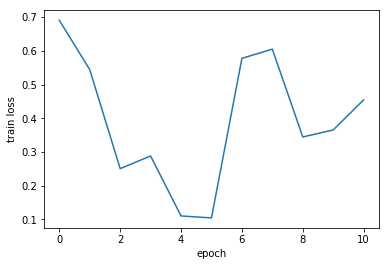

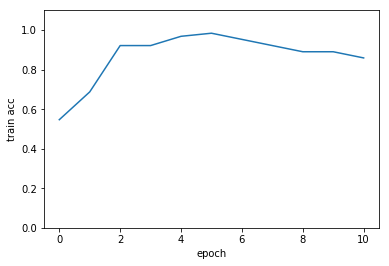

Train Loss : 0.4546 Acc : 0.8594


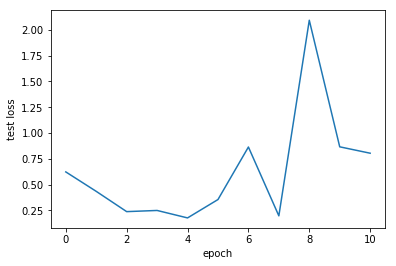

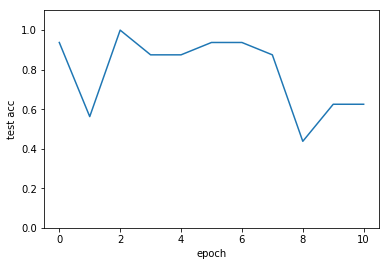

Test Loss : 0.8041 Acc : 0.6250


Train Loss : 0.9587 Acc : 0.7500


Test Loss : 1.0027 Acc : 0.6875


Train Loss : 0.3685 Acc : 0.8281


Test Loss : 1.0200 Acc : 0.6250


Train Loss : 0.1197 Acc : 0.9688


Test Loss : 0.7959 Acc : 0.6875


Train Loss : 0.2496 Acc : 0.9062


Test Loss : 0.4022 Acc : 0.8125


Train Loss : 0.1063 Acc : 0.9844


Test Loss : 0.3416 Acc : 0.8750


Train Loss : 0.0710 Acc : 0.9844


Test Loss : 0.4104 Acc : 0.8750


Train Loss : 0.1187 Acc : 0.9531


Test Loss : 0.4211 Acc : 0.8750


Train Loss : 0.2007 Acc : 0.9531


Test Loss : 0.3604 Acc : 0.8750


Train Loss : 0.0989 Acc : 0.9844


Test Loss : 0.3135 Acc : 0.8750


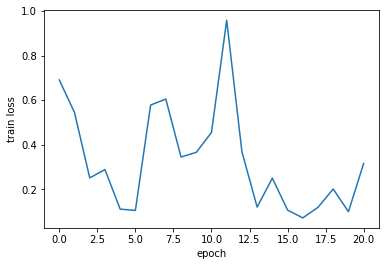

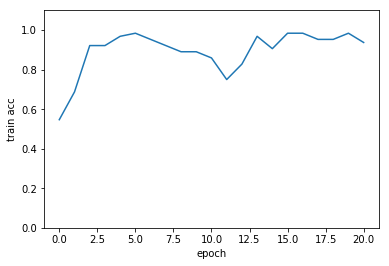

Train Loss : 0.3157 Acc : 0.9375


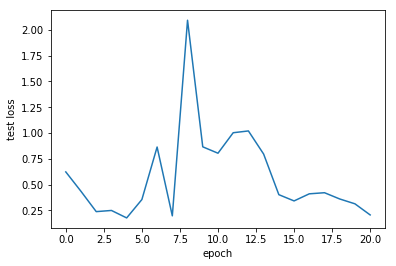

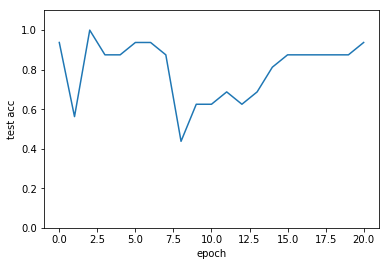

Test Loss : 0.2058 Acc : 0.9375


Train Loss : 0.0341 Acc : 1.0000


Test Loss : 0.2241 Acc : 0.9375


Train Loss : 0.1527 Acc : 0.9531


Test Loss : 0.2247 Acc : 0.9375


Train Loss : 0.0773 Acc : 0.9844


Test Loss : 0.2374 Acc : 0.9375


Train Loss : 0.0959 Acc : 0.9688


Test Loss : 0.2638 Acc : 0.9375


Train Loss : 0.0742 Acc : 0.9844


Test Loss : 0.2171 Acc : 0.9375


Train Loss : 0.1282 Acc : 0.9688


Test Loss : 0.2193 Acc : 0.9375


Train Loss : 0.0168 Acc : 1.0000


Test Loss : 0.2401 Acc : 0.9375


Train Loss : 0.0957 Acc : 0.9688


Test Loss : 0.2489 Acc : 0.9375


Train Loss : 0.1527 Acc : 0.9688


Test Loss : 0.2480 Acc : 0.9375


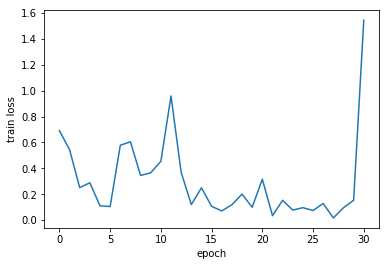

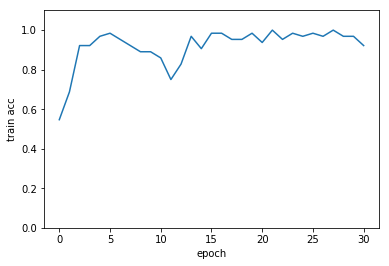

Train Loss : 1.5437 Acc : 0.9219


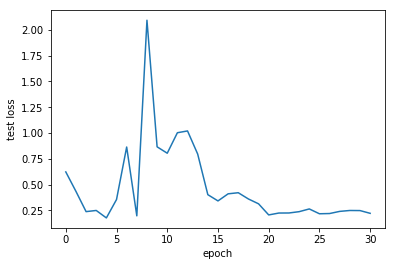

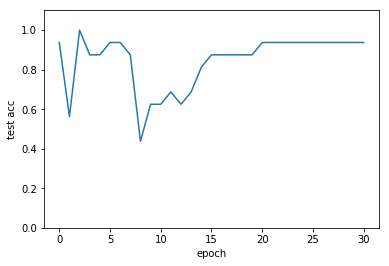

Test Loss : 0.2214 Acc : 0.9375


Train Loss : 0.0840 Acc : 0.9844


Test Loss : 0.4147 Acc : 0.8750


Train Loss : 0.0619 Acc : 0.9844


Test Loss : 0.4129 Acc : 0.8750


Train Loss : 0.0066 Acc : 1.0000


Test Loss : 0.3536 Acc : 0.8750


Train Loss : 0.0376 Acc : 0.9844


Test Loss : 0.3311 Acc : 0.8750


Train Loss : 0.1996 Acc : 0.9531


Test Loss : 0.2700 Acc : 0.9375


Train Loss : 0.1831 Acc : 0.9688


Test Loss : 0.2625 Acc : 0.9375


Train Loss : 0.2158 Acc : 0.9531


Test Loss : 0.2720 Acc : 0.8750


Train Loss : 0.1252 Acc : 0.9688


Test Loss : 0.4632 Acc : 0.8750


Train Loss : 0.0642 Acc : 0.9844


Test Loss : 0.4231 Acc : 0.8750


In [111]:
train_loss_history = []
train_acc_history = []
test_loss_history = []
test_acc_history = []

model.to('cuda')

for i, epoc in enumerate(pb(range(EPOCHS))):

    # train

    model.train()

    epoch_loss = 0.0
    epoch_corrects = 0

    for batch in pb(train_dataloader):

        optimizer.zero_grad()

        with torch.set_grad_enabled(True):
            output_dict = model(batch['waveform'].float().to(device))
            preds = output_dict['clipwise_output']
            loss = criterion(preds, batch['target'].float().to(device))
            pred_labels = torch.argmax(preds, 1)
            actual_labels = torch.argmax(batch['target'], 1).to(device)

            loss.backward()
            optimizer.step()

            epoch_loss += loss.item() * batch['waveform'].size(0)
            epoch_corrects += torch.sum(pred_labels == actual_labels)
    
    epoch_loss = epoch_loss / len(train_dataloader.dataset)
    epoch_acc = epoch_corrects.double() / len(train_dataloader.dataset)
    train_loss_history.append(epoch_loss)
    train_acc_history.append(epoch_acc)

    if (i % 10) == 0 and i > 0:
        plt.plot(train_loss_history)
        plt.ylabel('train loss')
        plt.xlabel('epoch')
        plt.show()
        plt.plot(train_acc_history)
        plt.ylim(0, 1.1)
        plt.ylabel('train acc')
        plt.xlabel('epoch')
        plt.show()

    print('Train Loss : {:.4f} Acc : {:.4f}'.format(epoch_loss, epoch_acc))

    # validation

    model.eval()

    epoch_loss = 0.0
    epoch_corrects = 0

    for batch in pb(test_dataloader):

        with torch.set_grad_enabled(False):
            output_dict = model(batch['waveform'].float().to(device))
            preds = output_dict['clipwise_output']
            loss = criterion(preds, batch['target'].float().to(device))
            pred_labels = torch.argmax(preds, 1)
            actual_labels = torch.argmax(batch['target'], 1).to(device)

            epoch_loss += loss.item() * batch['waveform'].size(0)
            epoch_corrects += torch.sum(pred_labels == actual_labels)
    
    epoch_loss = epoch_loss / len(test_dataloader.dataset)
    epoch_acc = epoch_corrects.double() / len(test_dataloader.dataset)
    test_loss_history.append(epoch_loss)
    test_acc_history.append(epoch_acc)

    if (i % 10) == 0 and i > 0:
        plt.plot(test_loss_history)
        plt.ylabel('test loss')
        plt.xlabel('epoch')
        plt.show()
        plt.plot(test_acc_history)
        plt.ylim(0, 1.1)
        plt.ylabel('test acc')
        plt.xlabel('epoch')
        plt.show()

    print('Test Loss : {:.4f} Acc : {:.4f}'.format(epoch_loss, epoch_acc))

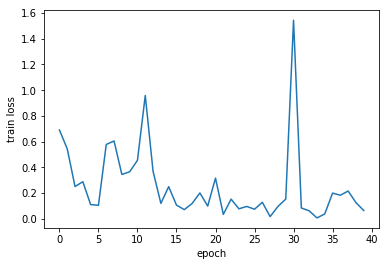

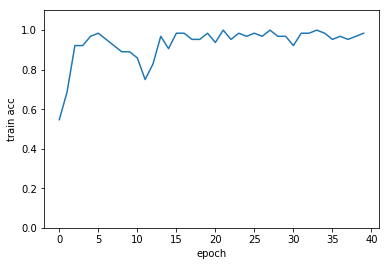

In [112]:
plt.plot(train_loss_history)
plt.ylabel('train loss')
plt.xlabel('epoch')
plt.show()
plt.plot(train_acc_history)
plt.ylim(0, 1.1)
plt.ylabel('train acc')
plt.xlabel('epoch')
plt.show()

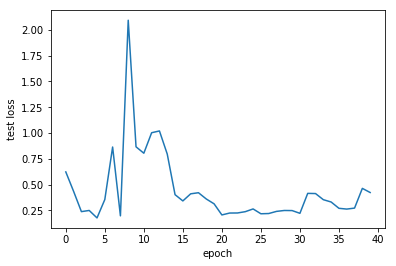

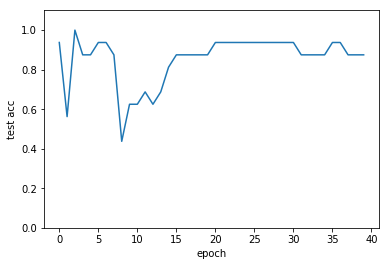

In [113]:
plt.plot(test_loss_history)
plt.ylabel('test loss')
plt.xlabel('epoch')
plt.show()
plt.plot(test_acc_history)
plt.ylim(0, 1.1)
plt.ylabel('test acc')
plt.xlabel('epoch')
plt.show()